# Optimized Version of Calibration Algorithm

In [62]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    gray = image[:, :, 0]
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)
    return thresh

def intensity_hist(image, axis=0, show_plot=False):
    img = image if axis == 0 else image.T
    intensity = [row.sum() // 255 for row in img]
    return intensity

def pairwise_distances(values):
    num_points, num_features = values.shape
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = np.sqrt(np.sum((values[i] - values[j]) ** 2))

    return distances

def cluster_values(values, threshold):
    values = np.array(values).reshape(-1, 1)
    distances = pairwise_distances(values)
    adjacency_matrix = distances < threshold
    clusters = []
    for i in range(len(values)):
        found_cluster = False
        for cluster in clusters:
            if any(adjacency_matrix[i, c] for c in cluster):
                cluster.append(i)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append([i])
    clustered_values = [[values[i][0] for i in cluster] for cluster in clusters]
    return clustered_values

def get_peaks(intensity_hist, cluster_distance):
    first_derivative = np.diff(intensity_hist)
    potential_peaks = np.where((first_derivative[:-1] >= 0) & (first_derivative[1:] <= 0))[0] + 1
    intensity_clust = cluster_values(potential_peaks, cluster_distance)
    for i in range(len(intensity_clust)):
        intensity_clust[i] = np.mean(intensity_clust[i])
    return intensity_clust

def get_circles(image, cluster_distance=3, show_plot=True):
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x, cluster_distance)
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y, cluster_distance)
    circles = [(x, y) for x in peaks_x for y in peaks_y]
    return np.array(circles), len(peaks_x), len(peaks_y)

def calibrate_svd(image, gauss_kernel=(15, 15), block_size=31, c=3, cluster_distance=3):
    thresh = generate_threshold_img(image, gauss_kernel, block_size, c)
    circles, nb_x, nb_y = get_circles(thresh, cluster_distance)
    circles = circles[np.lexsort((circles[:, 0], circles[:, 1]))]
    
    ## Matrix Construction
    B = np.concatenate((circles[:,0], circles[:,1])).reshape(-1,1)
    num_circles = len(circles)
    A = np.zeros((num_circles*2, 4))
    A[:num_circles, 0] = 1
    A[:num_circles, 2] = np.tile(np.arange(nb_x), num_circles // nb_x + 1)[:num_circles]
    A[num_circles:, 1] = 1
    A[num_circles:, 3] = np.repeat(np.arange(nb_y), nb_x)[:num_circles]

    # SVD
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    S_inv = np.diag(1 / S)
    cx_0, cy_0, dx, dy = Vt.T @ S_inv @ U.T @ B

    fig = plt.figure(figsize=FIGSIZE)
    plt.imshow(image, cmap='gray')
    for i in np.arange(dx, im.shape[0], dx):
        plt.axhline(i, color='red', linestyle='--', linewidth=1)
    for j in np.arange(dy, im.shape[1], dy):
        plt.axvline(j, color='red', linestyle='--', linewidth=1)
    plt.show()
    
    print(f"Reference circle: ({cx_0[0]},{cy_0[0]})")
    print(f"Steps/Mean diameters: dx {dx[0]} dy {dy[0]}")

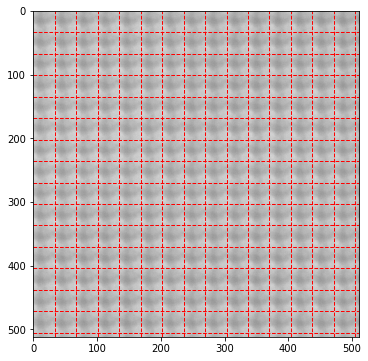

Reference circle: (-2.9227941176470793,-1.2499999999999893)
Steps/Mean diameters: dx 33.67720588235292 dy 33.6875


In [63]:
im = cv2.imread("../img/pcv_image_calibration_medium_exposure.png")
calibrate_svd(im)